# Face Mask Detection (GITHUB)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


import imutils
from imutils import paths

import cv2


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout , Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical 

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report 


from warnings import filterwarnings as w; w('ignore')

## Hyperparameters

In [2]:
#deep learning hyperparameters
lr = 1e-4
epochs = 30
batch = 32

## Initializations

In [3]:
img_paths = list(paths.list_images('dataset'))
data = []
labels = []

## Store images and labels | Preprocess 

In [ ]:
for path in img_paths:
    label = path.split(os.path.sep)[-2]
    
    image = load_img(path, target_size = (224,224))
    
    image = img_to_array(image)
    
    image = preprocess_input(image)
    data.append(image)
    labels.append(label)
    
data = np.array(data, dtype = 'float32')
labels = np.array(labels)



## One-Hot Encode | Data Augmentation

In [5]:
# Convert the labels into a one-hot encoded form
lb  = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

(xtrain,xtest,ytrain,ytest) = train_test_split(data, labels, test_size = 0.2, stratify = labels, random_state = 0)


aug = ImageDataGenerator(rotation_range = 20, zoom_range = 0.15, width_shift_range = 0.2, height_shift_range = 0.2,
                         shear_range = 0.15, horizontal_flip = True, fill_mode =  "nearest")



## Use MobileNet as pre-trained backend model

In [ ]:
basemodel = MobileNetV2(weights = "imagenet", include_top = False, input_tensor = Input(shape = (224,224,3)))

head = basemodel.output

head = AveragePooling2D(pool_size = (7,7))(head)
head = Flatten(name = 'flatten')(head)
head = Dense(128, activation = 'relu')(head)
head = Dropout(0.5)(head)
head = Dense(128, activation = 'relu')(head)
head = Dropout(0.5)(head)
head = Dense(2, activation = 'softmax')(head)

model = Model(inputs = basemodel.input, outputs = head)

for layer in basemodel.layers:
    layer.trainable = False  
    




In [ ]:
opt = Adam(lr = lr, decay = lr/epochs)

model.compile(loss = 'binary_crossentropy' ,optimizer  = opt, metrics = ['accuracy'])

history = model.fit(aug.flow(xtrain, ytrain, batch_size = batch), steps_per_epoch = len(xtrain)//batch, 
                   validation_data = (xtest,ytest), validation_steps = len(xtest)//batch, epochs = epochs)


## Evaluating

In [ ]:
pred = model.predict(xtest, batch_size = batch)
ypred = np.argmax(pred, axis = 1)

print("Classification Report")
print(classification_report(ytest.argmax(axis=1),ypred, target_names = lb.classes_))

#Save the trained model
model.save('models/mob_model.h5', save_format = "h5")


## Plot the training and the testing curve

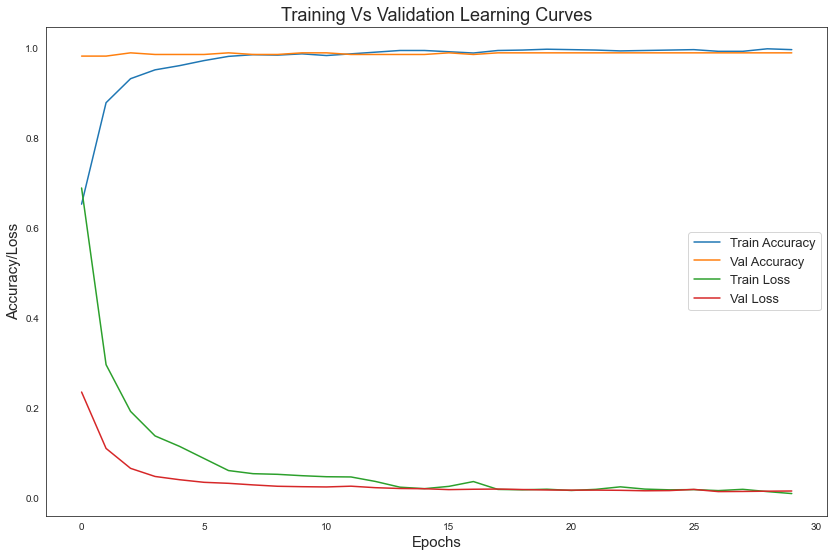

In [9]:
num = epochs
sns.set_style('white')
plt.figure(figsize = (14,9))
plt.plot(np.arange(0,num), history.history['accuracy'], label = 'Train Accuracy')
plt.plot(np.arange(0,num), history.history['val_accuracy'], label = 'Val Accuracy')
plt.plot(np.arange(0,num), history.history['loss'], label = 'Train Loss')
plt.plot(np.arange(0,num), history.history['val_loss'], label = 'Val Loss')
plt.title("Training Vs Validation Learning Curves", fontsize = 18)
plt.xlabel("Epochs", fontsize = 15)
plt.ylabel("Accuracy/Loss", fontsize = 15)
plt.legend(loc = "center right", fontsize =13)
#plt.savefig('plots/learning_curve2.png')
plt.show()



# THE END